In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!unzip '/content/drive/MyDrive/Colab Notebooks/news category/Data.zip' -d '/content/drive/MyDrive/Colab Notebooks/news category/'

Archive:  /content/drive/MyDrive/Colab Notebooks/news category/Data.zip
  inflating: /content/drive/MyDrive/Colab Notebooks/news category/Participants_Data_News_category/Sample_submission.xlsx  
  inflating: /content/drive/MyDrive/Colab Notebooks/news category/Participants_Data_News_category/Data_Test.xlsx  
  inflating: /content/drive/MyDrive/Colab Notebooks/news category/Participants_Data_News_category/Data_Train.xlsx  


In [4]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
!pip install langdetect


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
     |████████████████████████████████| 981 kB 25.9 MB/s 
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993242 sha256=08578809fabaa8a0e351cc0d1ab844b6b4d745bf58775a69e5cab64b8cf443a3
  Stored in directory: /root/.cache/pip/wheels/c5/96/8a/f90c59ed25d75e50a8c10a1b1c2d4c402e4dacfa87f3aff36a
Successfully built langdetect


In [5]:
import pandas as pd
import seaborn as sns
import numpy as np
import re
import string
from langdetect import detect
from wordcloud import WordCloud, STOPWORDS , ImageColorGenerator
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from collections import Counter
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer


In [6]:
path = "/content/drive/MyDrive/Colab Notebooks/news category/"
df = pd.read_excel(path+ "Participants_Data_News_category/Data_Train.xlsx",usecols=['STORY','SECTION']) #read trainning data
df.head(5)

,STORY,SECTION
0,But the most painful was the huge reversal in ...,3
1,How formidable is the opposition alliance amon...,0
2,Most Asian currencies were trading lower today...,3
3,"If you want to answer any question, click on ‘...",1
4,"In global markets, gold prices edged up today ...",3


In [54]:
test_df = pd.read_excel(path + 'Participants_Data_News_category/Data_Test.xlsx')     #read test data
test_df.head()

,STORY
0,2019 will see gadgets like gaming smartphones ...
1,It has also unleashed a wave of changes in the...
2,It can be confusing to pick the right smartpho...
3,The mobile application is integrated with a da...
4,We have rounded up some of the gadgets that sh...


In [7]:
#training data's share and name of columns
print('Dataset size:',df.shape)
print('Columns are:',df.columns)

Dataset size: (7628, 2)
Columns are: Index(['STORY', 'SECTION'], dtype='object')


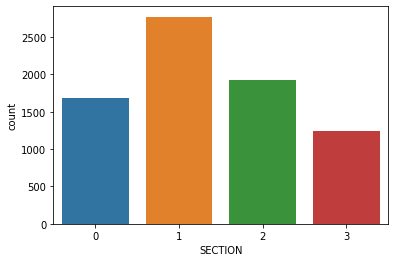

In [9]:
#section destribution
sns.countplot(x = 'SECTION', data = df)

In [10]:
tagging_regex = re.compile(r"@\S*")
url_pattern = re.compile(r'https?://\S+|www\.\S+')
weird_thing_pattern = re.compile(r"\^\S*")
new_line_pattern = re.compile(r"\n+\S*")

chat_words = {
    "AFAIK": "As Far As I Know",
    "AFK": "Away From Keyboard",
    "ASAP": "As Soon As Possible",
    "ATK": "At The Keyboard",
    "ATM": "At The Moment",
    "A3": "Anytime, Anywhere, Anyplace",
    "BAK": "Back At Keyboard",
    "BBL": "Be Back Later",
    "BBS": "Be Back Soon",
    "BFN": "Bye For Now",
    "B4N": "Bye For Now",
    "BRB": "Be Right Back",
    "BRT": "Be Right There",
    "BTW": "By The Way",
    "B4": "Before",
    "B4N": "Bye For Now",
    "CU": "See You",
    "CUL8R": "See You Later",
    "CYA": "See You",
    "FAQ": "Frequently Asked Questions",
    "FC": "Fingers Crossed",
    "FWIW": "For What It's Worth",
    "FYI": "For Your Information",
    "GAL": "Get A Life",
    "GG": "Good Game",
    "GN": "Good Night",
    "GMTA": "Great Minds Think Alike",
    "GR8": "Great!",
    "G9": "Genius",
    "IC": "I See",
    "ICQ": "I Seek you (also a chat program)",
    "ILU": "ILU: I Love You",
    "IMHO": "In My Honest/Humble Opinion",
    "IMO": "In My Opinion",
    "IOW": "In Other Words",
    "IRL": "In Real Life",
    "KISS": "Keep It Simple, Stupid",
    "LDR": "Long Distance Relationship",
    "LMAO": "Laugh My A.. Off",
    "LOL": "Laughing Out Loud",
    "LTNS": "Long Time No See",
    "L8R": "Later",
    "MTE": "My Thoughts Exactly",
    "M8": "Mate",
    "NRN": "No Reply Necessary",
    "OIC": "Oh I See",
    "PITA": "Pain In The A..",
    "PRT": "Party",
    "PRW": "Parents Are Watching",
    "ROFL": "Rolling On The Floor Laughing",
    "ROFLOL": "Rolling On The Floor Laughing Out Loud",
    "ROTFLMAO": "Rolling On The Floor Laughing My Ass Off",
    "SK8": "Skate",
    "STATS": "Your sex and age",
    "ASL": "Age, Sex, Location",
    "THX": "Thank You",
    "TTFN": "Ta-Ta For Now!",
    "TTYL": "Talk To You Later",
    "U": "You",
    "U2": "You Too",
    "U4E": "Yours For Ever",
    "WB": "Welcome Back",
    "WTF": "What The F...",
    "WTG": "Way To Go!",
    "WUF": "Where Are You From?",
    "W8": "Wait",
    "IMMA": "I am going to",
    "2NITE": "tonight",
    "DMED": "mesaged",
    'DM': "message",
    "SMH": "I am dissapointed"
}

contractions = {
    "ain't": "are not",
    "aren't": "are not",
    "can't": "cannot",
    "can't've": "cannot have",
    "'cause": "because",
    "could've": "could have",
    "couldn't": "could not",
    "couldn't've": "could not have",
    "didn't": "did not",
    "doesn't": "does not",
    "don't": "do not",
    "hadn't": "had not",
    "hadn't've": "had not have",
    "hasn't": "has not",
    "haven't": "have not",
    "he'd": "he would",
    "he'd've": "he would have",
    "he'll": "he will",
    "he'll've": "he shall have / he will have",
    "he's": "he is",
    "how'd": "how did",
    "how'd'y": "how do you",
    "how'll": "how will",
    "how's": "how is",
    "i'd": "I would",
    "i'd've": "I would have",
    "i'll": "I will",
    "i'll've": "I will have",
    "i'm": "I am",
    "i've": "I have",
    "isn't": "is not",
    "it'd": "it would",
    "it'd've": "it would have",
    "it'll": "it will",
    "it'll've": "it will have",
    "it's": "it is",
    "let's": "let us",
    "ma'am": "madam",
    "mayn't": "may not",
    "might've": "might have",
    "mightn't": "might not",
    "mightn't've": "might not have",
    "must've": "must have",
    "mustn't": "must not",
    "mustn't've": "must not have",
    "needn't": "need not",
    "needn't've": "need not have",
    "o'clock": "of the clock",
    "oughtn't": "ought not",
    "oughtn't've": "ought not have",
    "shan't": "shall not",
    "sha'n't": "shall not",
    "shan't've": "shall not have",
    "she'd": "she would",
    "she'd've": "she would have",
    "she'll": "she will",
    "she'll've": "she will have",
    "she's": "she is",
    "should've": "should have",
    "shouldn't": "should not",
    "shouldn't've": "should not have",
    "so've": "so have",
    "so's": "so is",
    "that'd": "that had",
    "that'd've": "that would have",
    "that's": "that is",
    "there'd": "there would",
    "there'd've": "there would have",
    "there's": "there is",
    "they'd": "they would",
    "they'd've": "they would have",
    "they'll": "they will",
    "they're": "they are",
    "they've": "they have",
    "to've": "to have",
    "wasn't": "was not",
    "we'd": "we would",
    "we'd've": "we would have",
    "we'll": "we will",
    "we'll've": "we will have",
    "we're": "we are",
    "we've": "we have",
    "weren't": "were not",
    "what'll": "what will",
    "what're": "what are",
    "what's": "what is",
    "what've": "what have",
    "when's": "when is",
    "when've": "when have",
    "where'd": "where did",
    "where's": "where is",
    "where've": "where have",
    "who'll": "who will",
    "who's": "who is",
    "who've": "who have",
    "why's": "why is",
    "why've": "why have",
    "will've": "will have",
    "won't": "will not",
    "won't've": "will not have",
    "would've": "would have",
    "wouldn't": "would not",
    "wouldn't've": "would not have",
    "y'all": "you all",
    "y'all'd": "you all would",
    "y'all'd've": "you all would have",
    "y'all're": "you all are",
    "y'all've": "you all have",
    "you'll": "you will",
    "you're": "you are",
    "you've": "you have",
}



In [11]:
def remove_emoji(inputString):
    return inputString.encode('ascii', 'ignore').decode('ascii')


def remove_url(string):
    return url_pattern.sub(r'', string)

def remove_chat_words_and_contractions(string):
    new_text = []
    for word in string.split(' '):
        if word.upper() in chat_words.keys():
            new_text += chat_words[word.upper()].lower().split(' ')
        if word.lower() in contractions.keys():
            new_text += contractions[word.lower()].split(' ')
        else:
            new_text.append(word)
            
    return ' '.join(new_text)


PUNCT_TO_REMOVE = string.punctuation
def remove_punctuation(text):
    """custom function to remove the punctuation"""
    return text.translate(str.maketrans('', '', PUNCT_TO_REMOVE))



In [14]:
def clean_message(message):
    # Remove user taggings
    message = re.sub(tagging_regex, '', message)
    
    # Remove the emojis
    message = remove_emoji(message)
    
    # Remove urls
    message = remove_url(message)
    
    # Remove the chat words and contractions
    message = remove_chat_words_and_contractions(message)
    
    # Remove weird things
    message = weird_thing_pattern.sub(r'', message)

    # Change new line to dot
    message = new_line_pattern.sub(r'.', message)
    
    # Remove punctuation
    message = remove_punctuation(message)
    
    # Remove start and end whitespace
    message = message.strip()
    
    # Make multiple spaces become a single space
    message = ' '.join(message.split())
    
    # Lower case the message
    message = message.lower()
    
    return message

df['cleaned_text'] = df.apply(lambda row: clean_message(row['STORY']), axis=1)            #cleaning training data

In [55]:
test_df['cleaned_text'] = test_df.apply(lambda row: clean_message(row['STORY']), axis=1) #cleaning test data

In [56]:
print("before cleaning STORY")
print(test_df.STORY[1])
print("After cleaning story")
print(test_df.cleaned_text[1])


before cleaning STORY
It has also unleashed a wave of changes in the MCU that will make sure its future is a lot different than its past


Kevin Feige had signalled diversity and more representation in the post-phase 3 MCU and Endgame does a lot to showcase the initiative
After cleaning story
it has also unleashed a wave of changes in the mcu that will make sure its future is a lot different than its past feige had signalled diversity and more representation in the postphase 3 mcu and endgame does a lot to showcase the initiative


In [16]:
print("before cleaning STORY")
print(df.STORY[1])
print("After cleaning story")
print(df.cleaned_text[1])


before cleaning STORY
How formidable is the opposition alliance among Congress, Jharkhand Mukti Morcha (JMM) and Jharkhand Vikas Morcha (Prajatantrik)?
After cleaning story
how formidable is the opposition alliance among congress jharkhand mukti morcha jmm and jharkhand vikas morcha prajatantrik


In [17]:
stop_words = stopwords.words('english')

# Remove stop words from training data
df['cleaned_text'] = df['cleaned_text'].str.split().apply(lambda x: [word for word in x if word not in stop_words]).apply(lambda x: ' '.join(x))

In [57]:
# Remove stop words from test data
test_df['cleaned_text'] = test_df['cleaned_text'].str.split().apply(lambda x: [word for word in x if word not in stop_words]).apply(lambda x: ' '.join(x))

In [58]:
print("before removieing stopwords: ",test_df['STORY'][1])
print("After removieing stopwords: ",test_df['cleaned_text'][1])

before removieing stopwords:  It has also unleashed a wave of changes in the MCU that will make sure its future is a lot different than its past


Kevin Feige had signalled diversity and more representation in the post-phase 3 MCU and Endgame does a lot to showcase the initiative
After removieing stopwords:  also unleashed wave changes mcu make sure future lot different past feige signalled diversity representation postphase 3 mcu endgame lot showcase initiative


In [18]:
print("before removieing stopwords: ",df['STORY'][1])
print("After removieing stopwords: ",df['cleaned_text'][1])

before removieing stopwords:  How formidable is the opposition alliance among Congress, Jharkhand Mukti Morcha (JMM) and Jharkhand Vikas Morcha (Prajatantrik)?
After removieing stopwords:  formidable opposition alliance among congress jharkhand mukti morcha jmm jharkhand vikas morcha prajatantrik


In [19]:
#frequent words from training data

cnt = Counter()
for text in df["cleaned_text"].values:
    for word in text.split():
        cnt[word] += 1
        
cnt.most_common(10)

[('said', 3707),
 ('also', 2590),
 ('india', 1818),
 ('new', 1721),
 ('congress', 1651),
 ('bjp', 1563),
 ('party', 1464),
 ('one', 1462),
 ('year', 1399),
 ('like', 1356)]

In [59]:
#frequent words from test data

test_cnt = Counter()
for text in test_df["cleaned_text"].values:
    for word in text.split():
        test_cnt[word] += 1
        
test_cnt.most_common(10)

[('said', 1219),
 ('also', 977),
 ('new', 688),
 ('india', 648),
 ('one', 539),
 ('like', 490),
 ('people', 459),
 ('would', 455),
 ('congress', 425),
 ('smartphone', 424)]

In [20]:
#rare words removal from training data
n_rare_words = 10
RAREWORDS = set([w for (w, wc) in cnt.most_common()[:-n_rare_words-1:-1]])
def remove_rarewords(text):
    """custom function to remove the rare words"""
    return " ".join([word for word in str(text).split() if word not in RAREWORDS])

df["cleaned_text"] = df["cleaned_text"].apply(lambda text: remove_rarewords(text))

In [60]:
#rare words removal from test data
n_rare_words = 10
RAREWORDS = set([w for (w, wc) in test_cnt.most_common()[:-n_rare_words-1:-1]])
test_df["cleaned_text"] = test_df["cleaned_text"].apply(lambda text: remove_rarewords(text))

In [21]:
print("Before lemmatization : ",df['cleaned_text'][1])

Before lemmatization :  formidable opposition alliance among congress jharkhand mukti morcha jmm jharkhand vikas morcha prajatantrik


In [22]:


lemmatizer = WordNetLemmatizer()
wordnet_map = {"N":wordnet.NOUN, "V":wordnet.VERB, "J":wordnet.ADJ, "R":wordnet.ADV}
def lemmatize_words(text):
    pos_tagged_text = nltk.pos_tag(text.split())
    return " ".join([lemmatizer.lemmatize(word, wordnet_map.get(pos[0], wordnet.NOUN)) for word, pos in pos_tagged_text])

df["cleaned_text"] = df["cleaned_text"].apply(lambda text: lemmatize_words(text))       #lemmiatize training data

print("After lemmatization : ",df['cleaned_text'][1])       

After lemmatization :  formidable opposition alliance among congress jharkhand mukti morcha jmm jharkhand vikas morcha prajatantrik


In [61]:
test_df["cleaned_text"] = test_df["cleaned_text"].apply(lambda text: lemmatize_words(text)) #lemmiatize test data

(-0.5, 399.5, 199.5, -0.5)

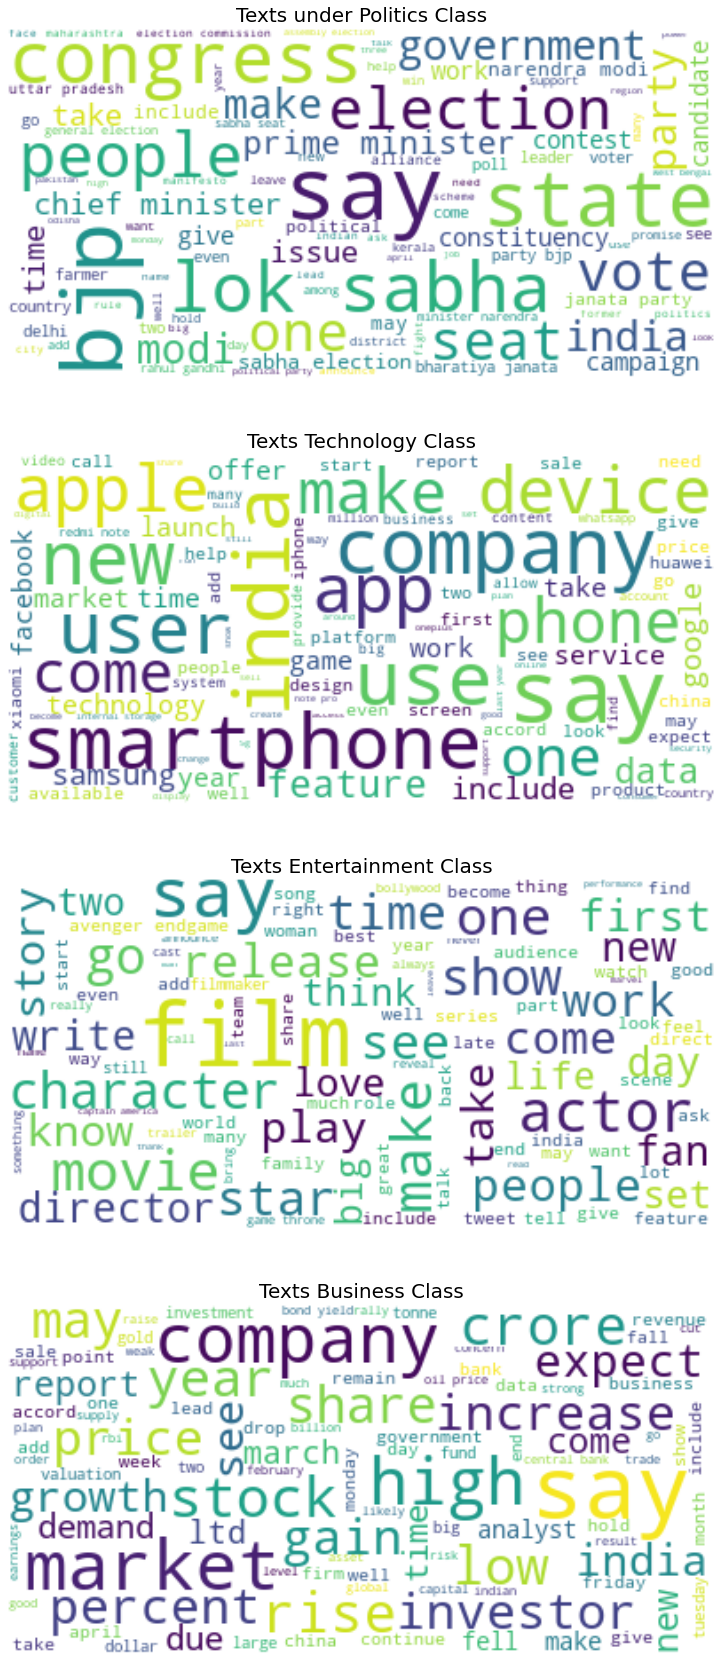

In [24]:
#wordcloud to see importance of word for each label

# Start with one review:
df_NB = df[df['SECTION']==0]
df_SE = df[df['SECTION']==1]
df_RE = df[df['SECTION']==2]
df_TH = df[df['SECTION']==3]
text_NB = " ".join(review for review in df_NB.cleaned_text)
text_SE = " ".join(review for review in df_SE.cleaned_text)
text_RE = " ".join(review for review in df_RE.cleaned_text)
text_TH = " ".join(review for review in df_TH.cleaned_text)

fig, ax = plt.subplots(4, 1, figsize  = (30,30))
# Create and generate a word cloud image:
wordcloud_NB = WordCloud(max_font_size=50,max_words=100,background_color="white").generate(text_NB)
wordcloud_SE = WordCloud(max_font_size=50,max_words=100, background_color="white").generate(text_SE)
wordcloud_RE = WordCloud(max_font_size=50,max_words=100, background_color="white").generate(text_RE)
wordcloud_TH = WordCloud(max_font_size=50,max_words=100,background_color="white").generate(text_TH)


# Display the generated image:
ax[0].imshow(wordcloud_NB, interpolation='bilinear')
ax[0].set_title('Texts under Politics Class',fontsize=20)
ax[0].axis('off')

ax[1].imshow(wordcloud_SE, interpolation='bilinear')
ax[1].set_title('Texts Technology Class',fontsize=20)
ax[1].axis('off')

ax[2].imshow(wordcloud_RE, interpolation='bilinear')
ax[2].set_title('Texts Entertainment Class',fontsize=20)
ax[2].axis('off')

ax[3].imshow(wordcloud_TH, interpolation='bilinear')
ax[3].set_title('Texts Business Class',fontsize=20)
ax[3].axis('off')

In [25]:
df.head()

,STORY,SECTION,cleaned_text
0,But the most painful was the huge reversal in ...,3,painful huge reversal fee income unheard among...
1,How formidable is the opposition alliance amon...,0,formidable opposition alliance among congress ...
2,Most Asian currencies were trading lower today...,3,asian currency trade low today south korean 04...
3,"If you want to answer any question, click on ‘...",1,want answer question click answer click answer...
4,"In global markets, gold prices edged up today ...",3,global market gold price edge today disappoint...


In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7628 entries, 0 to 7627
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   STORY         7628 non-null   object
 1   SECTION       7628 non-null   int64 
 2   cleaned_text  7628 non-null   object
dtypes: int64(1), object(2)
memory usage: 178.9+ KB


In [67]:
from sklearn.metrics import mean_squared_error,confusion_matrix, precision_score, recall_score, auc,roc_curve,accuracy_score,classification_report,f1_score
from sklearn.model_selection import train_test_split

In [29]:
#divide the model for trainning and testing
df.STORY=df.STORY.apply(str)
X = df.STORY.values
y = df.SECTION
#categories = ['Politics', 'Technology', 'Entertainment', 'Business']  #targeted labels

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 42)

#checking...
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)


(6102,)
(1526,)
(6102,)
(1526,)


In [38]:
#confusion matrix

def conf_matrix(pred,classfier):
  predictions = pred
  y_pred = np.array(predictions)
  cm = confusion_matrix(y_test, y_pred) 
# Transform to df for easier plotting
  cm_df = pd.DataFrame(cm,
                       index = ['Politics', 'Technology', 'Entertainment', 'Business'], 
                       columns = ['Politics', 'Technology', 'Entertainment', 'Business'])
  plt.figure(figsize=(8,6))
  sns.heatmap(cm_df, annot=True,cmap="YlGnBu", fmt='g')
  plt.title('\n'+classfier+'Accuracy: {0:.2f}'.format(accuracy_score(y_test, y_pred)*100))
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.xticks(rotation = 45)
  plt.yticks(rotation = 45)
  plt.show()
  plt.close()

In [43]:
#report generation

def report_generate(pred,classfier):
  report = pd.DataFrame(classification_report(y_true = y_test, y_pred = pred, output_dict=True)).transpose()
  report = report.rename(index={'0': 'Politics','1':'Technology','2':'Entertainment','3':'Business'})
  report[['precision','recall','f1-score']]=report[['precision','recall','f1-score']].apply(lambda x: round(x*100,2))
  report=report.drop(["support"],axis=1)
  columns = ['precision','recall','f1-score']
  report.columns = columns
  plt = report.plot(kind='bar',figsize=(12,6))
  plot=plt.tick_params(rotation=40)
  return plot,report

In [50]:
from sklearn.pipeline import Pipeline
import warnings
warnings.filterwarnings("ignore")
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC,SVC
from sklearn.linear_model import SGDClassifier

**SGD CLASSIFIER**

In [31]:

TFIDF_SGD_pipeline = Pipeline([
                               
                ('tfidf', TfidfVectorizer(tokenizer=lambda x: x.split(),lowercase=False,max_features=13000,min_df=1,ngram_range=(1,2))),
                ('clf', OneVsRestClassifier(SGDClassifier(loss='hinge', penalty='l2', alpha=1e-4, random_state=42, max_iter=200, tol=None)))
            ])


TFIDF_SGD_pipeline.fit(X_train, y_train)
TFIDF_SGD_pipeline_prediction = TFIDF_SGD_pipeline.predict(X_test)

print('accuracy %s' % accuracy_score(TFIDF_SGD_pipeline_prediction, y_test))


accuracy 0.9698558322411533


,precision,recall,f1-score
Politics,98.06,94.12,96.05
Technology,97.45,97.45,97.45
Entertainment,96.09,97.76,96.92
Business,96.12,98.41,97.25
accuracy,96.99,96.99,96.99
macro avg,96.93,96.94,96.92
weighted avg,97.00,96.99,96.98


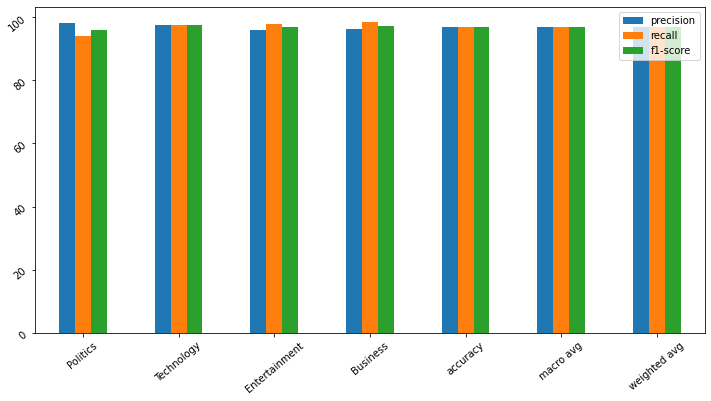

In [44]:
SGD_report=report_generate(TFIDF_SGD_pipeline_prediction,"SGD classifier")
SGD_report[1]

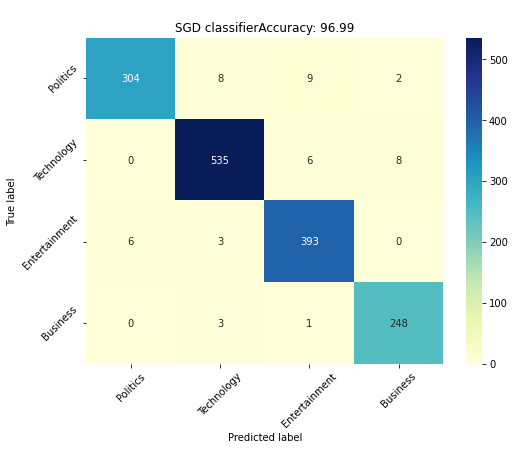

In [45]:
conf_matrix(TFIDF_SGD_pipeline_prediction,"SGD classifier")

**RANDOM FORREST**

In [46]:
from sklearn.ensemble import RandomForestClassifier
TFIDF_DT_pipeline = Pipeline([
                ('tfidf', TfidfVectorizer(tokenizer=lambda x: x.split(),lowercase=False,max_features=15000,min_df=5,ngram_range=(1,2))),
                ('clf', OneVsRestClassifier(RandomForestClassifier(n_estimators=200,criterion ='entropy')))
            ])


TFIDF_DT_pipeline.fit(X_train, y_train)
TFIDF_DT_pipeline_prediction = TFIDF_DT_pipeline.predict(X_test)
print('accuracy %s' % accuracy_score(TFIDF_DT_pipeline_prediction, y_test))



accuracy 0.9515072083879423


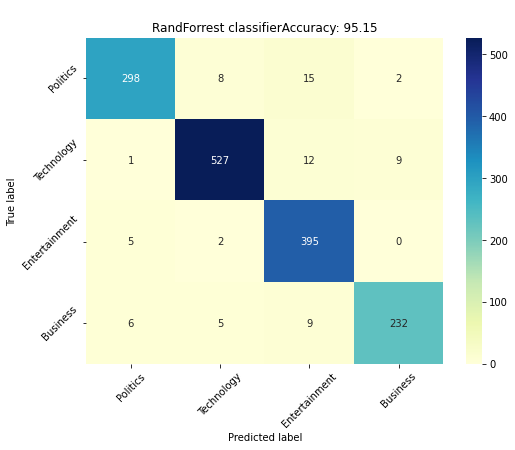

In [47]:

conf_matrix(TFIDF_DT_pipeline_prediction,"RandForrest classifier")

,precision,recall,f1-score
Politics,96.13,92.26,94.15
Technology,97.23,95.99,96.61
Entertainment,91.65,98.26,94.84
Business,95.47,92.06,93.74
accuracy,95.15,95.15,95.15
macro avg,95.12,94.64,94.83
weighted avg,95.24,95.15,95.15


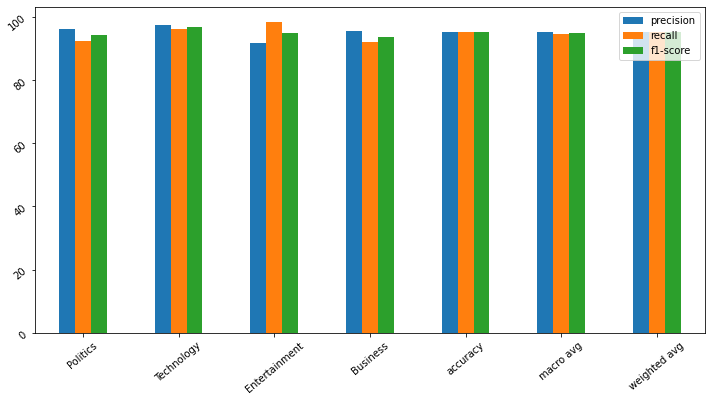

In [49]:
DT_report=report_generate(TFIDF_DT_pipeline_prediction,"RandForrest classifier")
DT_report[1]

**SVC**

In [51]:
TFIDF_SVC_pipeline = Pipeline([
                               
                ('tfidf', TfidfVectorizer(tokenizer=lambda x: x.split(),lowercase=False,max_features=8000,min_df=5,ngram_range=(1,2))),
                ('clf', OneVsRestClassifier(SVC(random_state=42)))
            ])


TFIDF_SVC_pipeline.fit(X_train, y_train)
TFIDF_SVC_pipeline_prediction = TFIDF_SVC_pipeline.predict(X_test)

print('accuracy %s' % accuracy_score(TFIDF_SVC_pipeline_prediction, y_test))


accuracy 0.9639580602883355


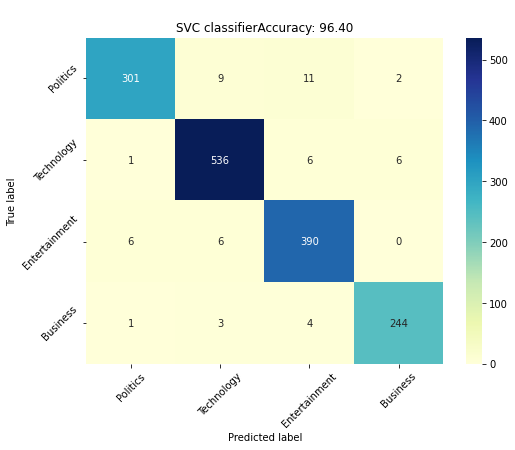

In [52]:
conf_matrix(TFIDF_SVC_pipeline_prediction,"SVC classifier")

,precision,recall,f1-score
Politics,97.41,93.19,95.25
Technology,96.75,97.63,97.19
Entertainment,94.89,97.01,95.94
Business,96.83,96.83,96.83
accuracy,96.40,96.40,96.40
macro avg,96.47,96.17,96.30
weighted avg,96.41,96.40,96.39


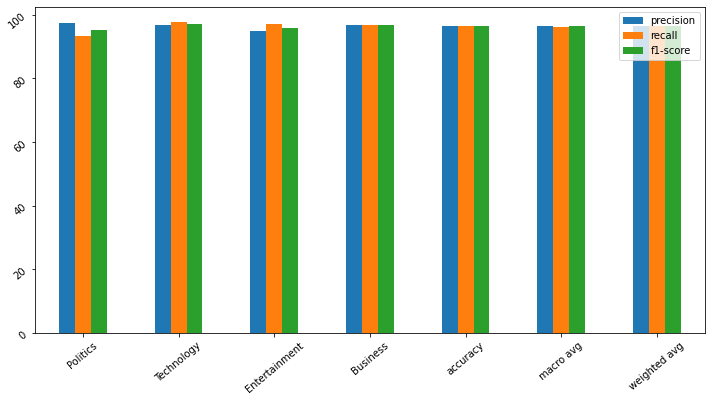

In [53]:
SVC_report=report_generate(TFIDF_SVC_pipeline_prediction,"SVC classifier")
SVC_report[1]

**Evaluation**

In [64]:
# Functions to compute True Positives, True Negatives, False Positives and False Negatives

def true_positive(y_true, y_pred):   
    tp = 0
    for yt, yp in zip(y_true, y_pred):
        if yt == 1 and yp == 1:
            tp += 1
    return tp

def true_negative(y_true, y_pred):
    tn = 0
    for yt, yp in zip(y_true, y_pred):
        if yt == 0 and yp == 0:
            tn += 1
    return tn

def false_positive(y_true, y_pred):
    fp = 0
    for yt, yp in zip(y_true, y_pred):
        if yt == 0 and yp == 1:
            fp += 1
    return fp

def false_negative(y_true, y_pred):
    fn = 0
    for yt, yp in zip(y_true, y_pred):
        if yt == 1 and yp == 0:
            fn += 1

In [65]:
#Computation of macro-averaged precision

def macro_precision(y_true, y_pred):
    # find the number of classes
    num_classes = len(np.unique(y_true))
    # initialize precision to 0
    precision = 0
    categories = 4
    # loop over all classes
    for class_ in range (categories):
        # all classes except current are considered negative
        temp_true = [1 if p == class_ else 0 for p in y_true]
        temp_pred = [1 if p == class_ else 0 for p in y_pred]
        # compute true positive for current class
        tp = true_positive(temp_true, temp_pred)
        # compute false positive for current class
        fp = false_positive(temp_true, temp_pred)
        # compute precision for current class
        temp_precision = tp / (tp + fp + 1e-6)
        # keep adding precision for all classes
        precision += temp_precision
        
    # calculate and return average precision over all classes
    precision /= num_classes
    return precision

In [66]:

MLA = {
     'SGD Classifier' : TFIDF_SGD_pipeline,
     'Random Forrest' : TFIDF_DT_pipeline,
     'SVC' : TFIDF_SVC_pipeline  
}

In [68]:
columns = []
compare = pd.DataFrame(columns = columns)
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes=4
row_index = 0
for name,alg in MLA.items():
    MLA_name = name
    predicted = alg.predict(X_test)
    micro_averaged_recall = recall_score(y_test, predicted, average = 'micro')
    macro_averaged_f1 = f1_score(y_test, predicted, average = 'macro')
    
    compare.loc[row_index,'Name'] = MLA_name
    compare.loc[row_index, 'Test Accuracy'] = round(alg.score(X_test, y_test), 4)
    compare.loc[row_index, 'Precision'] = macro_precision(y_test, predicted)
    compare.loc[row_index, 'Recall'] = micro_averaged_recall
    compare.loc[row_index, 'F1 Score'] = macro_averaged_f1
    row_index+=1
    
compare.sort_values(by = ['Test Accuracy'], ascending = False, inplace = True)    
compare

,Name,Test Accuracy,Precision,Recall,F1 Score
0,SGD Classifier,0.9699,0.969316,0.969856,0.969182
2,SVC,0.9640,0.964695,0.963958,0.963023
1,Random Forrest,0.9515,0.951205,0.951507,0.948347


**Submission**

**Since SGD performed the best. We will use the classifier for the predictions os testing data**

In [62]:
TFIDF_SGD_pipeline_prediction = TFIDF_SGD_pipeline.predict(test_df['cleaned_text'])

In [63]:
submission = pd.DataFrame({'SECTION':TFIDF_SGD_pipeline_prediction})
submission.to_excel(path + 'submission5.xlsx', index=False)